In [206]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

# Import Data

In [144]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

X_train = train.drop(columns=['Response'])
y_train = train['Response']

X_test = test.drop(columns=['Response'])
y_test = test['Response']

print("Data dims for train: ", X_train.shape, y_train.shape)
print("Data dims for test: ", X_test.shape, y_test.shape)

Data dims for train:  (1813, 27) (1813,)
Data dims for test:  (444, 27) (444,)


# GridSearchCV Hyperparameter Tuning Based On F1 Score

In [148]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

# Number of features to consider at every split
max_features = [int(x) for x in np.arange(start = 1, stop = 28, step = 1)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(start = 2, stop = 25, step = 4)]

param_grid = {
    'n_estimators': [2000],
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'oob_score': [True],
    'random_state': [1],
    'class_weight': ["balanced_subsample"],
    'max_samples': [0.8]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 10,
    n_jobs = -1,
    scoring = 'f1',
    return_train_score = True
)

g_search = grid_search.fit(X_train, y_train)

In [152]:
result = pd.DataFrame(g_search.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,6.291879,0.093574,0.237838,0.055368,True,balanced_subsample,2,1,0.8,1,...,0.782458,0.784314,0.784473,0.785714,0.788895,0.783362,0.779779,0.782051,0.785574,0.004261
1,6.548523,0.108076,0.274504,0.051954,True,balanced_subsample,2,2,0.8,1,...,0.798373,0.798603,0.794857,0.804424,0.799766,0.798830,0.792740,0.794360,0.798896,0.003894
2,8.084710,0.869951,0.325121,0.058204,True,balanced_subsample,2,3,0.8,1,...,0.797195,0.798359,0.793184,0.800471,0.797416,0.801643,0.793632,0.797879,0.799737,0.005157
3,7.479966,0.723488,0.243347,0.030055,True,balanced_subsample,2,4,0.8,1,...,0.800000,0.799060,0.798587,0.801881,0.800000,0.802825,0.793144,0.796921,0.801166,0.004964
4,6.912105,0.058953,0.228606,0.007025,True,balanced_subsample,2,5,0.8,1,...,0.804907,0.803509,0.800469,0.807737,0.800701,0.808910,0.799294,0.801414,0.805026,0.004470


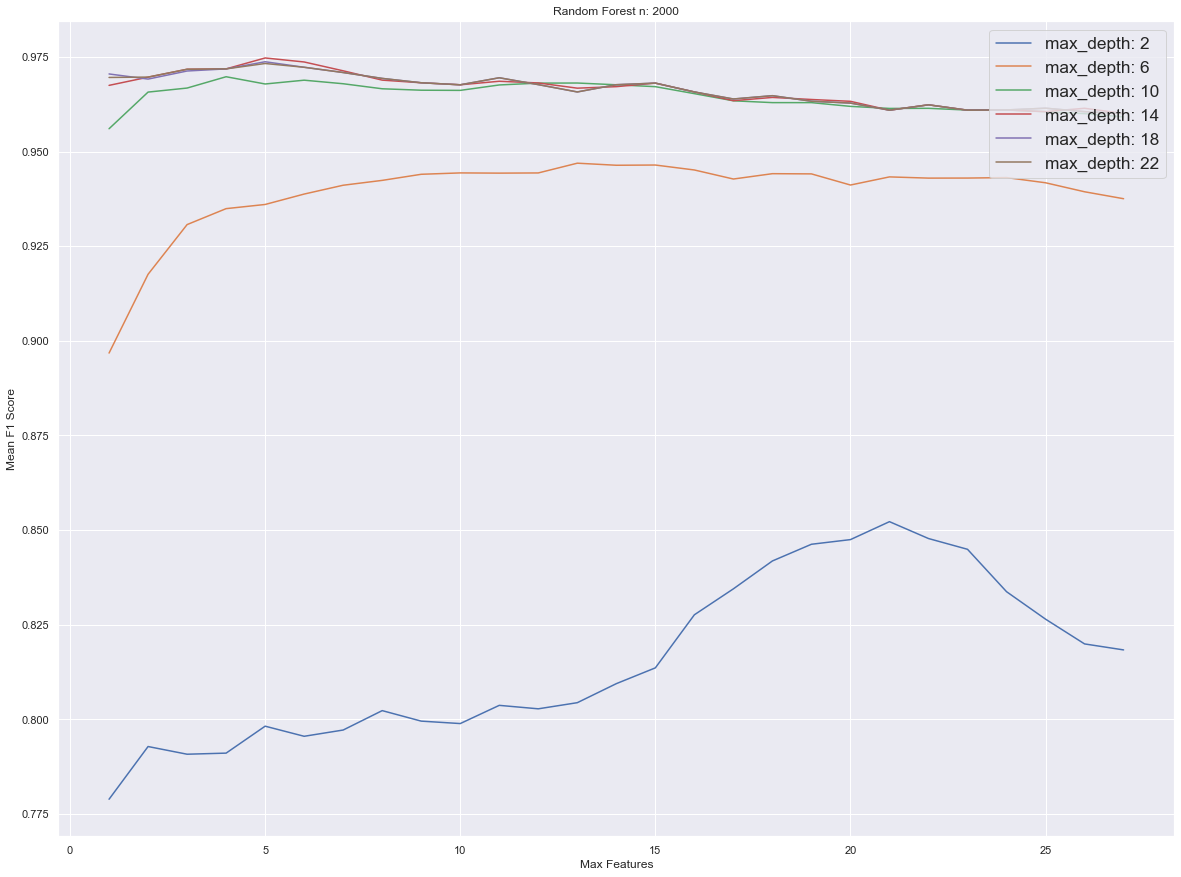

In [153]:
f, ax = plt.subplots(figsize = (20,15))

for depth in result['param_max_depth'].unique():
    df = result[result['param_max_depth'] == depth][['param_max_features','mean_test_score']]
    df = df.sort_values(by = ['param_max_features'])
    ax.plot(df['param_max_features'], df['mean_test_score'], label = 'max_depth: ' + str(depth))
    
ax.legend(loc = 1, fontsize = 'x-large')
ax.set_xlabel('Max Features', )
ax.set_ylabel('Mean F1 Score')
ax.set_title('Random Forest n: 2000')
ax.grid('on')

In [154]:
ovf = result[['param_max_depth','mean_train_score','mean_test_score']]
ovf = pd.DataFrame(ovf)
ovf['overfit']= (result['mean_train_score'] - result['mean_test_score'])
a = ovf.groupby('param_max_depth').mean()
a.head()

,mean_train_score,mean_test_score,overfit
param_max_depth,,,
2,0.829850,0.815560,0.014290
6,0.973656,0.939385,0.034271
10,0.999498,0.964496,0.035002
14,1.000000,0.966354,0.033646
18,1.000000,0.966342,0.033658


In [155]:
g_search.best_params_

{'bootstrap': True,
 'class_weight': 'balanced_subsample',
 'max_depth': 14,
 'max_features': 5,
 'max_samples': 0.8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000,
 'oob_score': True,
 'random_state': 1}

# Train optimized model

<AxesSubplot:>

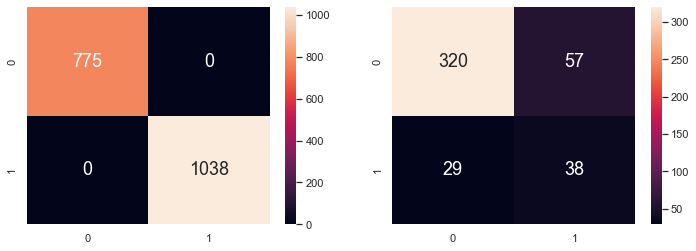

In [156]:
# Random Forest using Train Data
rforest = RandomForestClassifier(
    n_estimators = 2000,
    max_features = 5,
    max_depth = 14,
    min_samples_split = 2,
    min_samples_leaf = 1,
    bootstrap = True,
    oob_score = True,
    random_state = 123,
    class_weight = "balanced_subsample",
    max_samples = 0.8,
    n_jobs = -1
)
rforest.fit(X_train, y_train)

# Predict Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])

In [158]:
# check oob generalizability
rforest.oob_score_

0.9680088251516823

In [246]:
y_true = pd.DataFrame(y_test)
y_true

,Response
0,1
1,0
2,0
3,0
4,0
...,...
439,1
440,0
441,0
442,0


In [294]:
y_score = rforest.predict_proba(X_test)
y_score = pd.DataFrame(y_score[:,1], columns=["1"])
y_score

,1
0,0.469899
1,0.130454
2,0.067000
3,0.094807
4,0.034129
...,...
439,0.636988
440,0.173092
441,0.313567
442,0.139523


# ROC Curve & Precision Recall Curve

ROC AUC:  0.8264974860445782
PRC AUC:  0.5
Best threshold based on ROC:  0.2868392391605687
Best threshold based on PRC:  0.4398822451983703


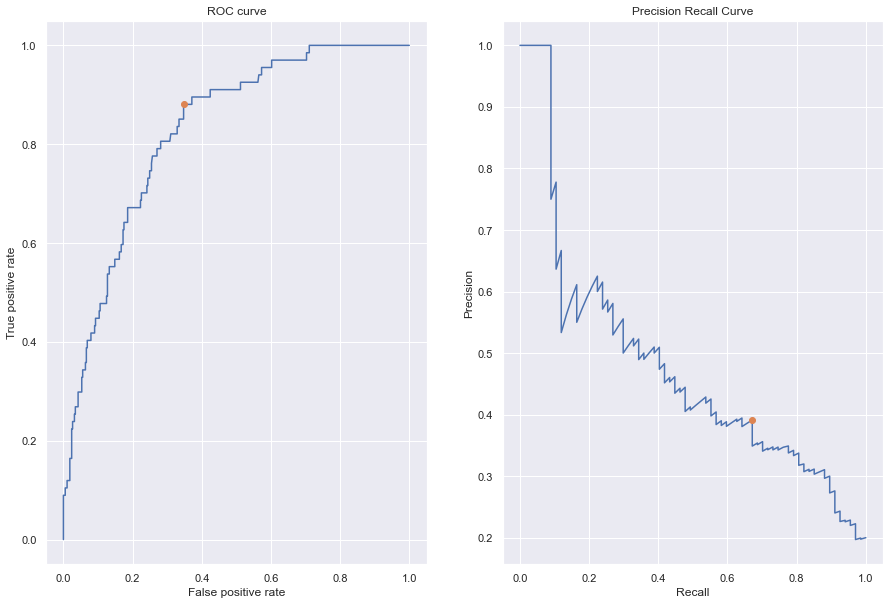

In [307]:
f, axes = plt.subplots(1, 2, figsize = (15, 10))

# ROC Curve via Youden's J statistic
fpr, tpr, roc_thresholds = roc_curve(y_true, y_score, pos_label = 1)
roc = np.column_stack((fpr, tpr, tpr-fpr, roc_thresholds))
roc = pd.DataFrame(roc, columns = ['FPR', 'TPR', 'TPR - FPR', 'Thresholds'])
roc = roc.sort_values(by='TPR - FPR', ascending=False)
auroc = metrics.auc(fpr, tpr)

axes[0].plot(fpr, tpr)
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].set_title('ROC curve')
axes[0].plot(0.347480, 0.880597, 'o')    

# PR Curve via F1 Score
# Note the last precision and recall does not have a corresponding threshold value so they should be left out
precision, recall, prc_thresholds = precision_recall_curve(y_true, y_score, pos_label = 1)
f1_score = (2* precision * recall) / (precision + recall)
prc = np.column_stack((precision[:-1], recall[:-1], f1_score[:-1], prc_thresholds))
prc = pd.DataFrame(prc, columns = ['Precision', 'Recall', 'F1 Score', 'Thresholds'])
prc = prc.sort_values(by='F1 Score', ascending=False)
auprc = metrics.auc(recall, precision)

axes[1].plot(recall, precision)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision Recall Curve')
axes[1].plot(0.671642, 0.391304, 'o')

print("ROC AUC: ", auroc)
print("PRC AUC: ", format(auprc, ".1f"))
print("Best threshold based on ROC: ", roc["Thresholds"].iloc[0])
print("Best threshold based on PRC: ", prc["Thresholds"].iloc[0])

In [308]:
roc.head()

,FPR,TPR,TPR - FPR,Thresholds
84,0.347480,0.880597,0.533117,0.286839
76,0.281167,0.805970,0.524803,0.335524
86,0.371353,0.895522,0.524170,0.264884
74,0.270557,0.791045,0.520488,0.346339
72,0.257294,0.776119,0.518825,0.356839


In [309]:
prc.head()

,Precision,Recall,F1 Score,Thresholds
210,0.391304,0.671642,0.494505,0.439882
209,0.387931,0.671642,0.491803,0.439194
208,0.384615,0.671642,0.489130,0.435758
216,0.394495,0.641791,0.488636,0.469152
207,0.381356,0.671642,0.486486,0.435731


In [365]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Initial performance
init_accuracy = accuracy_score(y_test, y_test_pred)
init_balanced = balanced_accuracy_score(y_test, y_test_pred)
init_Fscore = f1_score(y_test, y_test_pred)
init_recall = recall_score(y_test, y_test_pred)
init_precision = precision_score(y_test, y_test_pred)

# Change to optimal thresholds obtained from ROC and PRC
roc_pred = (y_score >= roc["Thresholds"].iloc[0]).astype('int')
prc_pred = (y_score >= prc["Thresholds"].iloc[0]).astype('int')

# Final performance
roc_accuracy = accuracy_score(y_test, roc_pred)
roc_balanced = balanced_accuracy_score(y_test, roc_pred)
roc_Fscore = f1_score(y_test, roc_pred)
roc_recall = recall_score(y_test, roc_pred)
roc_precision = precision_score(y_test, roc_pred)

prc_accuracy = accuracy_score(y_test, prc_pred)
prc_balanced = balanced_accuracy_score(y_test, prc_pred)
prc_Fscore = f1_score(y_test, prc_pred)
prc_recall = recall_score(y_test, prc_pred)
prc_precision = precision_score(y_test, prc_pred)

performance = {"Accuracy": [init_accuracy, roc_accuracy, prc_accuracy,],
               "Balanced Accuracy": [init_balanced, roc_balanced, prc_balanced],
               "F Score": [init_Fscore, roc_Fscore, prc_Fscore],
              "Recall": [init_recall, roc_recall, prc_recall],
              "Precision": [init_precision, roc_precision, prc_precision]}

final = pd.DataFrame(performance, index = ["Initial", "ROC", "PRC"])
final

,Accuracy,Balanced Accuracy,F Score,Recall,Precision
Initial,0.806306,0.707985,0.469136,0.567164,0.400000
ROC,0.686937,0.766558,0.459144,0.880597,0.310526
PRC,0.792793,0.742983,0.494505,0.671642,0.391304


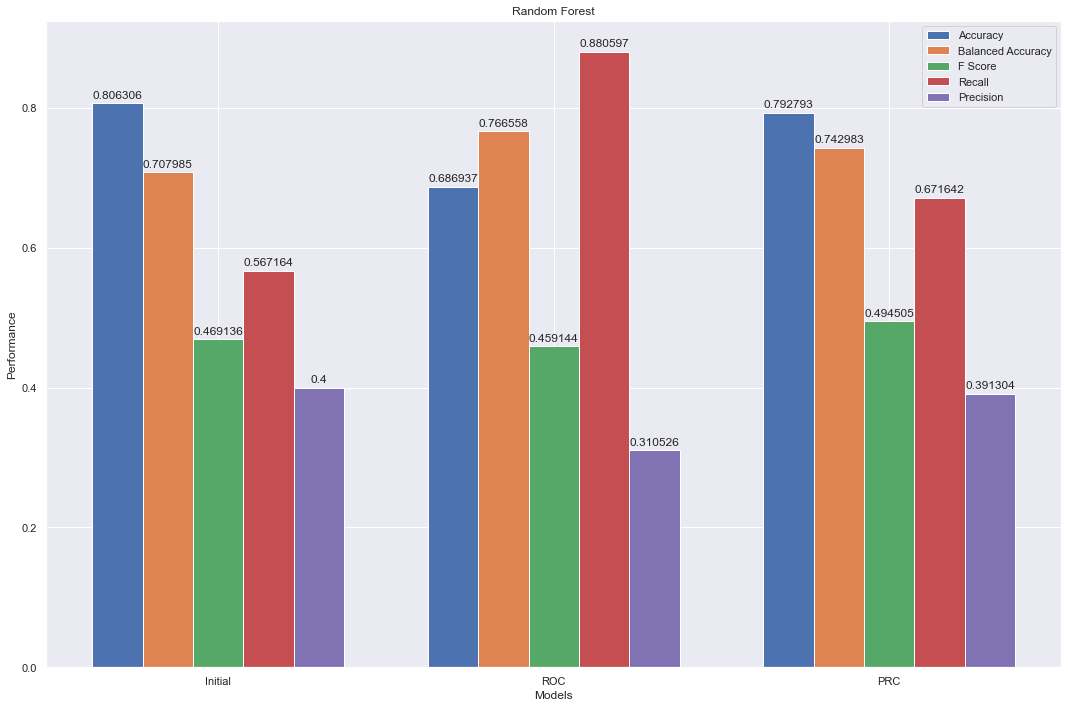

In [352]:
labels = list(final.index)
x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize = (15, 10))
first_col = ax.bar(x - 2*width, final["Accuracy"], width, label = 'Accuracy')
sec_col = ax.bar(x - 1*width, final["Balanced Accuracy"], width, label = "Balanced Accuracy")
third_col = ax.bar(x, final["F Score"], width, label = "F Score")
fourth_col = ax.bar(x + 1*width, final["Recall"], width, label = "Recall")
fifth_col = ax.bar(x + 2*width, final["Precision"], width, label = "Precision")

ax.set_ylabel("Performance")
ax.set_xlabel("Models")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Random Forest")
ax.legend(loc = 1)

ax.bar_label(first_col, padding=3)
ax.bar_label(sec_col, padding=3)
ax.bar_label(third_col, padding=3)
ax.bar_label(fourth_col, padding=3)
ax.bar_label(fifth_col, padding=3)

fig.tight_layout()

plt.show()

# Feature Importance (MDI & Permutation)

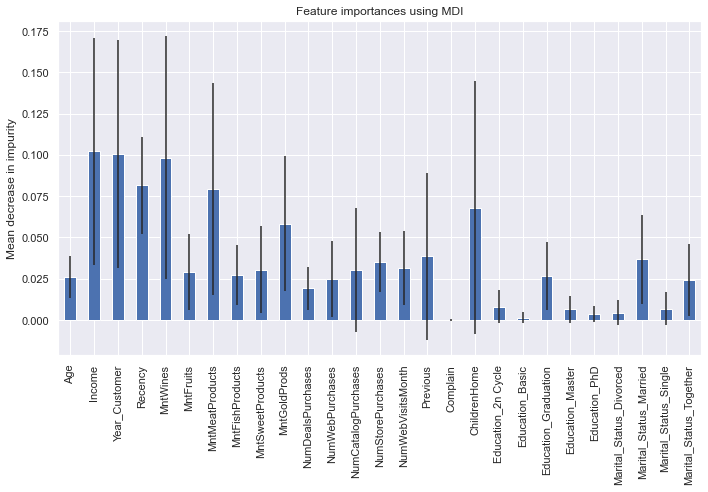

In [353]:
# Feature importance based on mean decrease in impurity (MDI)
importances = rforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in rforest.estimators_], axis=0)

rforest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 7))
rforest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

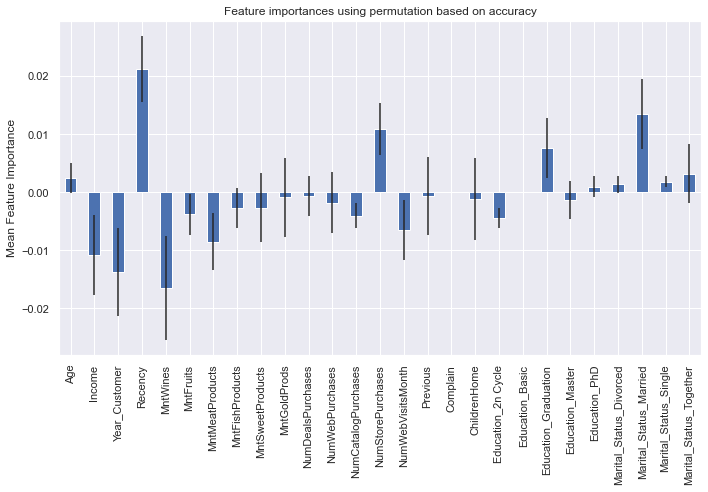

In [360]:
# Feature importance based on feature permutation
from sklearn.inspection import permutation_importance

result = permutation_importance(rforest, X_test, y_test, scoring = "accuracy", random_state = 0, n_repeats = 10, n_jobs = -1)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation based on accuracy")
ax.set_ylabel("Mean Feature Importance")
fig.tight_layout()
plt.show()

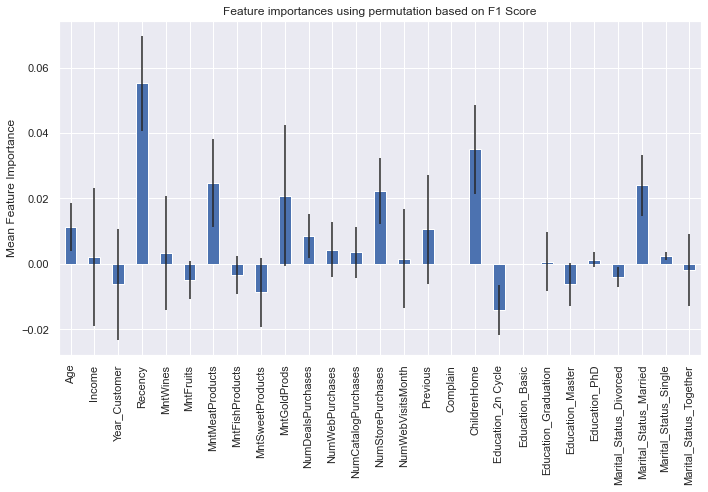

In [363]:
# Feature importance based on feature permutation
from sklearn.inspection import permutation_importance

result = permutation_importance(rforest, X_test, y_test, scoring = "f1", random_state = 0, n_repeats = 10, n_jobs = -1)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation based on F1 Score")
ax.set_ylabel("Mean Feature Importance")
fig.tight_layout()
plt.show()